In [ ]:
pip install stable-baselines3


  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0a2
    Uninstalling gymnasium-1.0.0a2:
      Successfully uninstalled gymnasium-1.0.0a2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
!pip install 'shimmy>=0.2.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.3/954.3 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.3.2 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0a2 which is incompatible.


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.83     |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    fps             | 736      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Evaluation after 1000 timesteps: Avg Reward = -19.299999237060547
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.21     |
|    ep_rew_mean     | -19.6    |
| time/              |          |
|    fps             | 835      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Evaluation after 2000 timesteps: Avg Reward = -11.100000381469727
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.73     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    fps          

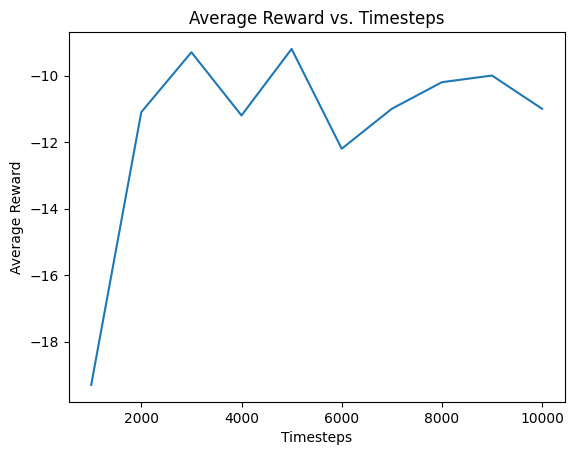

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

class GreenhouseEnv(gym.Env):
    def __init__(self, a_tank_capacity=1, b_tank_capacity=1, acid_tank_capacity=1, main_tank_capacity=10):
        super(GreenhouseEnv, self).__init__()

        self.a_tank_capacity = a_tank_capacity
        self.b_tank_capacity = b_tank_capacity
        self.acid_tank_capacity = acid_tank_capacity
        self.main_tank_capacity = main_tank_capacity

        # Define the observation space: [A level, B level, Acid level in container, pH]
        self.observation_space = spaces.Box(low=np.array([0, 0, 0, 5.5]),
                                            high=np.array([a_tank_capacity, b_tank_capacity, acid_tank_capacity, 7.5]),
                                            dtype=np.float32)

        # Define the action space: [Desired A mix, Desired B mix, Desired pH]
        self.action_space = spaces.Box(low=np.array([0, 0, 5.5]),
                                       high=np.array([a_tank_capacity, b_tank_capacity, 7.5]),
                                       dtype=np.float32)

        self.reset()

    def reset(self):
        self.a_level = random.uniform(0, self.a_tank_capacity)
        self.b_level = random.uniform(0, self.b_tank_capacity)
        self.acid_level = random.uniform(0, self.acid_tank_capacity)
        self.pH = random.uniform(5.5, 7.5)
        self.state = (self.a_level, self.b_level, self.acid_level, self.pH)
        return self.state

    def step(self, action):
        desired_a_mix, desired_b_mix, desired_pH = action

        supply_a = min(0, desired_a_mix - self.a_level)
        supply_b = min(0, desired_b_mix - self.b_level)

        acid_needed = self.calculate_acid_amount(self.pH, desired_pH)
        supply_acid = min(acid_needed, self.acid_level)

        self.a_level += supply_a
        self.b_level += supply_b
        self.acid_level -= supply_acid
        self.pH = desired_pH

        next_state = (self.a_level, self.b_level, self.acid_level, self.pH)

        # Define the reward function
        reward = -abs(self.pH - 6.5)  # For Lettuce, desirable range pH is 6.0-7.0
        if self.a_level < desired_a_mix or self.b_level < desired_b_mix or self.acid_level < acid_needed:
            reward -= 10  # Penalty for not meeting the supply

        done = self.a_level >= desired_a_mix and self.b_level >= desired_b_mix and self.pH <= desired_pH

        self.state = next_state
        return next_state, reward, done, {}

    def calculate_acid_amount(self, current_pH, target_pH):
        if current_pH <= target_pH:
            return 0
        acid_conc = 10**(-4)  # To be Updated
        initial_conc = 10**(-current_pH)
        desired_conc = 10**(-target_pH)

        acid_needed = abs(initial_conc - desired_conc) * self.main_tank_capacity / acid_conc
        return acid_needed

    def render(self, mode='human'):
        print(f"A level: {self.a_level}, B level: {self.b_level}, Acid level: {self.acid_level}, pH: {self.pH}")

def evaluate_agent(model, env, num_episodes=10):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    avg_reward = np.mean(total_rewards)
    return avg_reward

# Create the environment
env = make_vec_env(lambda: GreenhouseEnv(1, 1, 0.5), n_envs=1)

# Create the RL model
model = PPO("MlpPolicy", env, verbose=1)

# Training with periodic evaluation
total_timesteps = 10000
eval_interval = 1000
num_evals = total_timesteps // eval_interval
avg_rewards = []

for i in range(num_evals):
    model.learn(total_timesteps=eval_interval)
    avg_reward = evaluate_agent(model, env)
    avg_rewards.append(avg_reward)
    print(f"Evaluation after {eval_interval * (i+1)} timesteps: Avg Reward = {avg_reward}")

# Plotting the results
plt.plot(range(eval_interval, total_timesteps + eval_interval, eval_interval), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average Reward')
plt.title('Average Reward vs. Timesteps')
plt.show()
